In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import svm

from sklearn.preprocessing import LabelEncoder

# Rappel

Les problèmes de classification et de régression sont deux types de problèmes d'apprentissage supervisé en machine learning, et ils se distinguent principalement par la nature des données de sortie et les objectifs poursuivis. Voici une explication détaillée des différences entre ces deux types de problèmes :

1. Nature des données de sortie

- Classification :
  
La sortie d'un problème de classification est discrète. Il s'agit de prédire une catégorie ou une classe parmi un ensemble fini de classes possibles.

Exemples :
Prédire si un email est spam ou non-spam (problème binaire, 2 classes).
Classifier des images de chiens et de chats (problème multiclasse avec 2 classes).
Diagnostiquer une maladie parmi plusieurs types possibles (problème multiclasse avec plusieurs classes).

- Régression :

La sortie d'un problème de régression est continue. Il s'agit de prédire une valeur numérique en fonction des données d'entrée.

Exemples :
Prédire le prix d'une maison en fonction de caractéristiques telles que la superficie, le nombre de chambres, etc.
Prédire la température demain en fonction des données météorologiques historiques.
Prédire la consommation énergétique d'un bâtiment en fonction de différents facteurs.

2. Objectif de la tâche

- Classification :

L'objectif est de classifier correctement chaque observation en l'attribuant à une classe spécifique. On cherche à minimiser le taux d'erreur ou à maximiser la précision en assignant la bonne étiquette à chaque exemple. Les métriques courantes pour évaluer les performances sont :

Précision (accuracy).

Rappel (recall).

Score F1 (une moyenne harmonique entre précision et rappel).

AUC-ROC (aire sous la courbe ROC pour évaluer la capacité de discrimination).

- Régression :

L'objectif est de prédire des valeurs précises, et on cherche à minimiser l'écart entre la valeur prédite et la valeur réelle. On cherche à minimiser une mesure d'erreur, telle que :

Erreur quadratique moyenne (MSE).

Erreur absolue moyenne (MAE).

Erreur quadratique moyenne racine (RMSE).

La précision des valeurs prédictives est plus importante que leur classification dans des catégories spécifiques.

# Classifiez vos données avec une SVM à noyau

### Cours

In [3]:
data = pd.read_csv('winequality-white.csv', sep=';')

# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data['quality'].values

# transformer en un problème de classification binaire
y_class = np.where(y<6, 0, 1)

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Transformation du problème en classification binaire**

In [6]:
y_class = np.where(y < 6, 0, 1)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class, test_size=0.3 ) # 30% des données dans le jeu de test

In [8]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [9]:
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=0.01)  # rbf = modele gaussien

OK, nous pouvons enfin entraîner notre première SVM à noyau !

In [11]:
classifier.fit(X_train_std, y_train)

SVC(gamma=0.01)

Comment se comporte-t-elle sur le jeu de test ? Nous allons pour le comprendre regarder la courbe ROC.

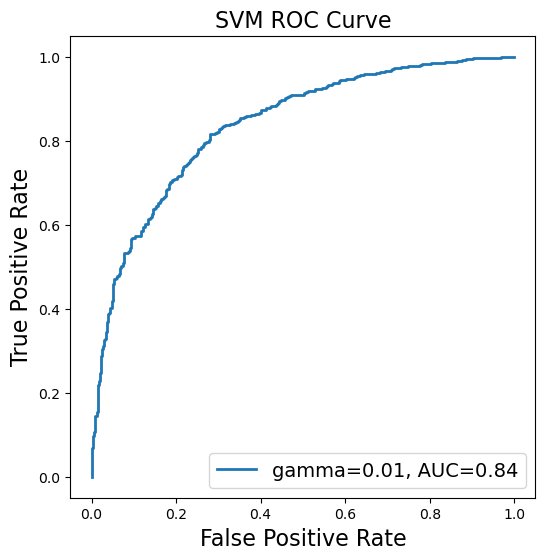

In [13]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)

# construire la courbe ROC
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

**Sélection des hyperparamètres**

Comme dans le cas de la SVM linéaire, il faut mettre en œuvre de bonnes pratiques de sélection de modèle (par exemple une validation croisée) pour choisir la meilleure valeur de C !

Nous allons ici utiliser une validation croisée sur le jeu d'entraînement pour sélectionner les valeurs optimales de C et de gamma parmi une grille de valeurs.

In [16]:
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)
print("valeurs de C :", C_range)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = 'roc_auc'

# initialiser une recherche sur grille
grid = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), 
                                    param_grid, 
                                    cv=5, # 5 folds de validation croisée  
                                    scoring=score)

# faire tourner la recherche sur grille
grid.fit(X_train_std, y_train)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))

valeurs de C : [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.84


Nous pouvons maintenant évaluer la performance de notre modèle optimisé sur le jeu de test :

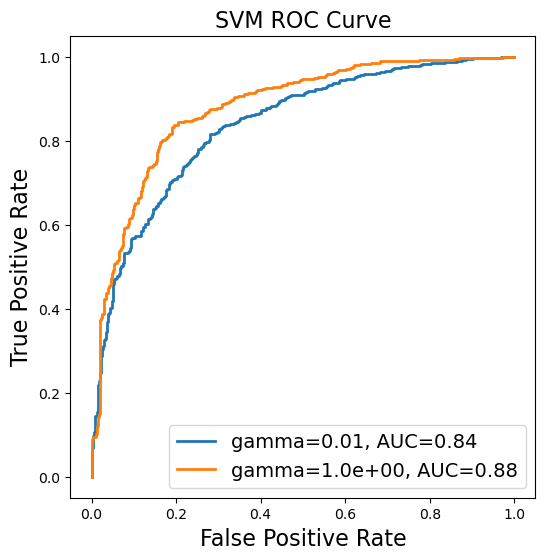

In [18]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = grid.decision_function(X_test_std)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % (grid.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

**Matrice de Gram**

Gamma contrôle la bande passante de la gaussienne : plus gamma est élevé, plus la gaussienne est étroite, autrement dit, plus la distance entre x et x' doit être faible pour que le noyau soit différent de 0.

Pour en visualiser l'effet, nous pouvons visualiser la matrice de Gram des donné.

Il peut arriver que la matrice de Gram de vos données, est à diagonale fortement dominante, autrement dit que les nombres sur sa diagonale ont des valeurs plusieurs ordres de grandeurs plus grandes que les autres. Dans ce cas, du point de vue numérique elle ressemblera à la matrice identité (fois un grand nombre réel), et la SVM ne pourra pas bien apprendre : c'est comme si vous lui disiez que chaque point n'est semblable qu'à lui-même, et extrêmement différent des autres

Calculons la matrice de Gram obtenue sur notre jeu d'entraînement quand gamma=0.01 .es

In [20]:
from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)

Nous allons réduire cette matrice à ses 100 premières lignes et 100 premières colonnes pour en faciliter la visualisation :

In [22]:
kmatrix100 = kmatrix[:100, :100]

Nous pouvons maintenant utiliser plt.pcolor pour visualiser cette matrice :

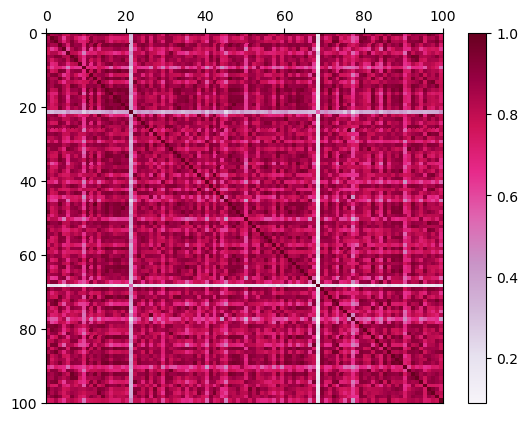

In [24]:
# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

Nous avons ici des valeurs de noyau comprises entre 0.40 et 1.0, avec une diagonale plus forte mais qui n'écrase pas la matrice.

Avec une valeur de gamma plus grande, par exemple, gamma=50, on obtient la matrice de Gram suivante :

In [26]:
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=50)

In [27]:
kmatrix100 = kmatrix[:100, :100]

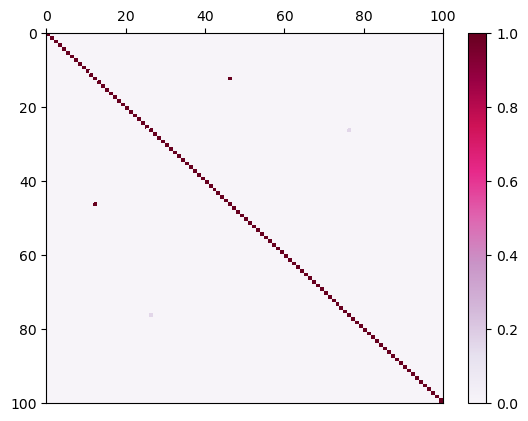

In [28]:
# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

Cette matrice est à diagonale dominante;

i l'on entraîne une SVM avec cette valeur de gamma, la courbe ROC serait beaucoup moins bonne.

### TP - À vous de jouer !

In [31]:
data = pd.read_csv('ecg.csv', sep=',', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Vérifier que l’échantillon est bien équilibré (c’est à dire que la proportion des électrocardiogrammes sains et comportant une anomalie sont sensiblement identiques).

In [33]:
data.iloc[:,-1].value_counts(normalize=True).round(2)

140
1.0    0.58
0.0    0.42
Name: proportion, dtype: float64

In [34]:
# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data.iloc[:,-1].values

In [35]:
y.shape

(4998,)

In [36]:
X.shape

(4998, 140)

Standardiser

In [38]:
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [39]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.3 ) # 30% des données dans le jeu de test

In [40]:
X_train.shape

(3498, 140)

In [41]:
X_test.shape

(1500, 140)

Construisez une SVM avec un gamma de 50 et observez sa courbe ROC comme vu dans le cours.

In [43]:
classifier = svm.SVC(kernel='rbf', gamma=50)  # rbf = modele gaussien

In [44]:
classifier.fit(X_train, y_train)

SVC(gamma=50)

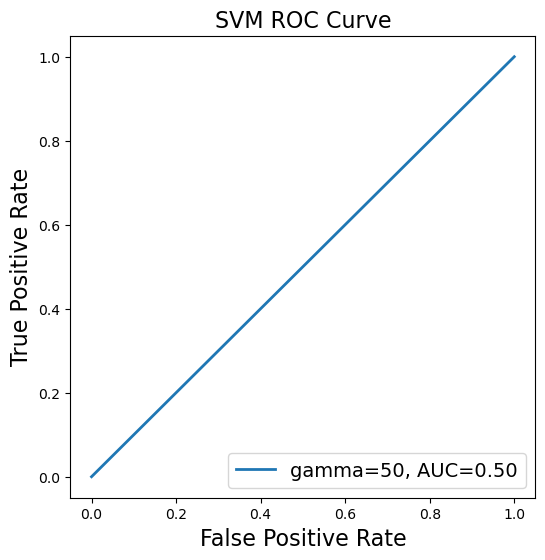

In [45]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test)

# construire la courbe ROC
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=50, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

Optimisez les performances de votre modèle à l’aide d’une validation croisée.

In [47]:
# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = 'roc_auc'

# initialiser une recherche sur grille
grid = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), 
                                    param_grid, 
                                    cv=5, # 5 folds de validation croisée  
                                    scoring=score)

# faire tourner la recherche sur grille
grid.fit(X_train, y_train)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))

The optimal parameters are {'gamma': 0.01} with a score of 1.00


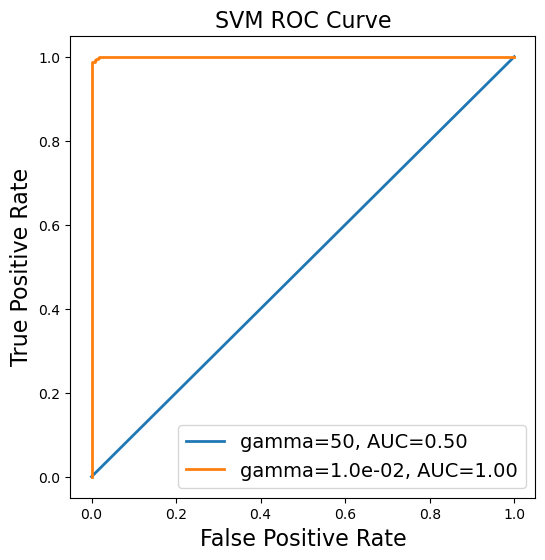

In [48]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = grid.decision_function(X_test)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=50, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % (grid.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

# Apprenez des étiquettes réelles avec une régression ridge à noyau

Il n'y a pas qu'aux SVM que l'on peut appliquer l'astuce du noyau ! Elle marche avec un certain nombre d'algorithmes linéaires, par exemple, la régression ridge régularisée.

### En pratique avec scikit-learn

Chargeons les données, séparons-les en un jeu d'entraînement et un jeu de test contenant respectivement 70% et 30% des données, et standardisons les variables sur le jeu d'entraînement.

In [51]:
# charger les données
data = pd.read_csv('winequality-white.csv', sep=';')

# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data['quality'].values

# créer un jeu d'entrainement et un jeu de test (30% des données)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
                                
# standardiser les données
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)                               

Nous pouvons maintenant entraîner une kRR sur le jeu d'entraînement en utilisant des paramètres par défaut pour le paramètre de régularisation et la bande passante du noyau RBF gaussien :

Pour visualiser les prédictions, on peut utiliser un nuage de points dans lequel la surface de chaque point est proportionnelle au nombre d'observations ayant exactement ces valeurs de score prédit et de score réel

In [53]:
from sklearn import kernel_ridge
predicteur = kernel_ridge.KernelRidge(
    alpha=1.0, # valeur par défaut 
    kernel='rbf', # noyau Gaussien
    gamma=0.01)   # valeur de 1/(2 * sigma**2)
                                     
# entraîner le classifieur sur le jeu d'entrainement
predicteur.fit(X_train_std, y_train)

# prédire sur le jeu de test
y_test_pred = predicteur.predict(X_test_std)

# calculer la RMSE sur le jeu de test
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print("RMSE: {:.2f}".format(rmse))

RMSE: 0.74


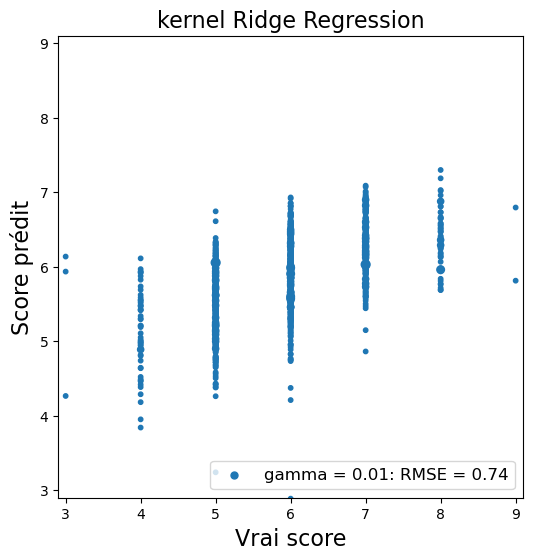

In [55]:
# créer une figure
fig = plt.figure(figsize=(6, 6))

# Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
# le nombre de ces paires.
# Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants 
# dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_test_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k]*10 for k in keys], 
            label="gamma = 0.01: RMSE = {:.2f}".format(rmse))

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

On observe une corrélation entre les scores prédits et les score réels.

Comme dans le cas de la SVM à noyau, le paramètre gamma du noyau RBF gaussien joue un rôle important : s'il est trop élevé, la matrice de Gram sur le jeu d'entraînement est dominée par sa diagonale et la kRR ne peut pas apprendre. Si l'on recommence avec gamma=50, on obtient les prédictions suivantes :

In [58]:
predicteur_50 = kernel_ridge.KernelRidge(
    alpha=1.0, # valeur par défaut 
    kernel='rbf', # noyau Gaussien
    gamma=50)   # valeur de 1/(2 * sigma**2)
                                     
# entraîner le classifieur sur le jeu d'entrainement
predicteur_50.fit(X_train_std, y_train)

# prédire sur le jeu de test
y_test_pred_50 = predicteur_50.predict(X_test_std)

# calculer la RMSE sur le jeu de test
rmse_50 = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_50))
print("RMSE: {:.2f}".format(rmse_50))

RMSE: 5.26


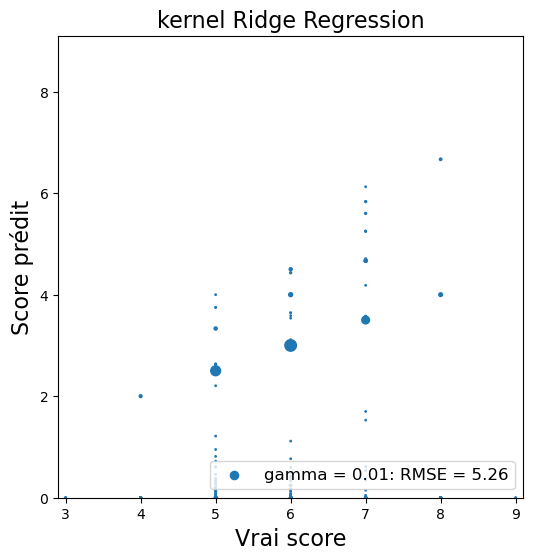

In [59]:
# créer une figure
fig = plt.figure(figsize=(6, 6))

# Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
# le nombre de ces paires.
# Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants 
# dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_test_pred_50)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label="gamma = 0.01: RMSE = {:.2f}".format(rmse_50))

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([2.9, 9.1])
plt.ylim([0, 9.1])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

Les prédictions avec gamma=50 sont de très mauvaise qualité!

Comme dans le cas de la régression ridge linéaire, il faut mettre en œuvre de bonnes pratiques de sélection de modèle (par exemple une validation croisée) pour choisir la meilleure valeur du paramètre de régularisation. Mais il y a maintenant des hyperparamètres supplémentaires : les paramètres du noyau !

Pour optimiser le paramètre de régularisation alpha et le paramètre gamma du noyau gaussien, on peut utiliser une recherche sur grille :

In [62]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_train_std, y_train)

# prédire sur le jeu de test avec le modèle sélectionné 
y_test_pred_cv = grid_pred.predict(X_test_std)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a score of {:.2f}".format(grid_pred.best_params_, grid_pred.best_score_))

# calculer la RMSE correspondante
rmse_cv = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cv))

The optimal parameters are {'alpha': 0.01, 'gamma': 0.01} with a score of -0.49


In [63]:
rmse_cv

0.7199294065017652

Le score est meilleur avec la validation croisée et le choix des hyperparamètres

# Entraînez un réseau de neurones simple

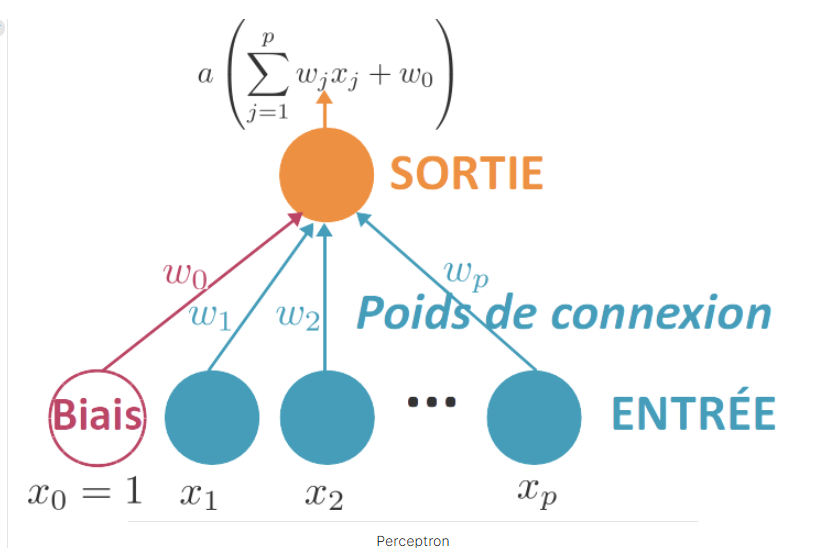

**Quelle fonction d'activation utiliser ?**

Dans le cas d'un problème de régression, il n'est pas nécessaire de transformer la somme pondérée reçue en entrée. La fonction d'activation est la fonction identité, elle retourne ce qu'elle a reçu en entier.

Dans le cas d'un problème de classification binaire, on peut utiliser une fonction de seuil :  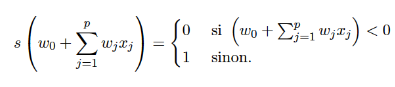



Comme dans le cas de la régression logistique, on peut aussi utiliser une fonction sigmoïde pour prédire la probabilité d'appartenir à la classe posi
1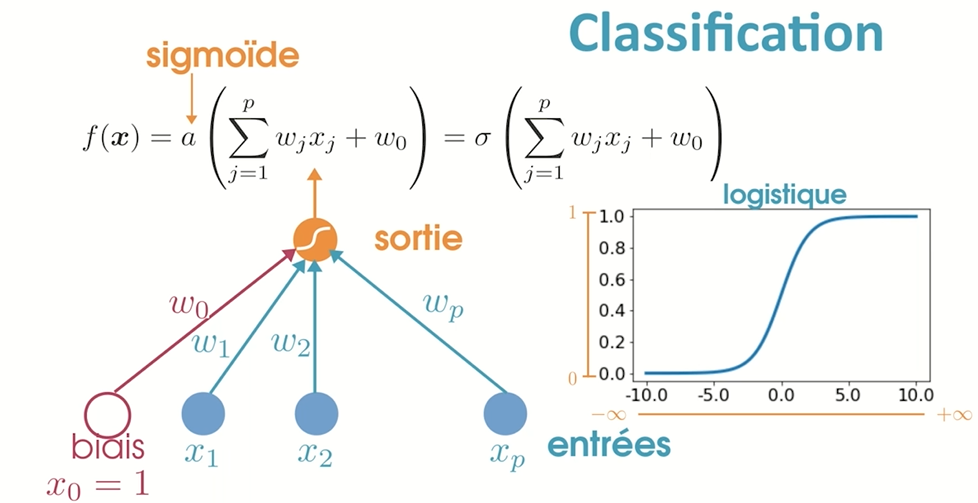xj)
 .

Dans le cas d'un problème de classification multi-classe, nous allons modifier l'architecture du perceptron. Au lieu d'utiliser une seule unité de sortie, il va en utiliser autant que de classes. Chacune de ces unités sera connectée à toutes les unités d'entrée. On aura donc ainsi K.(p+1) poids de connexion, où K est le nombre de

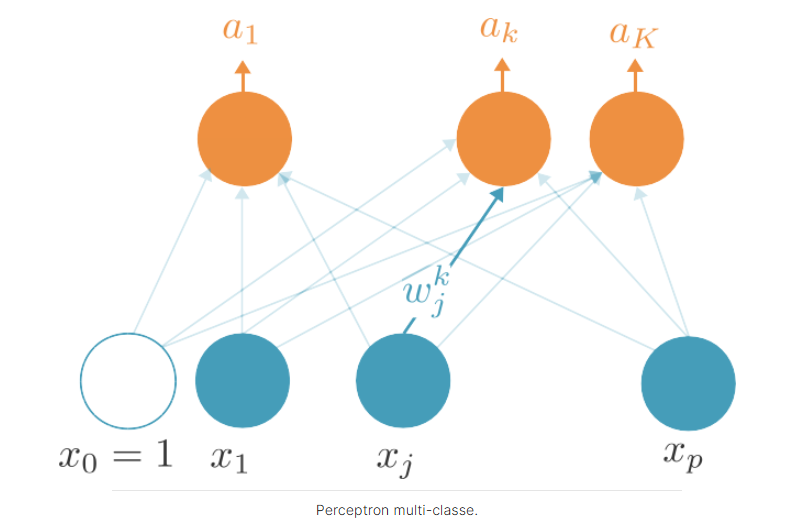 classes.

On peut alors utiliser comme fonction d'activation la fonction softmax. Il s'agit d'une généralisation de la sigmoïde, qui peut aussi s'écrire σ(u)=eu1+eu
 : nous allons utiliser σk(uk)=euk∑Kl=1eul
 . Si la sortie pour la classe k est suffisamment plus grande que celles des autres classes, son activation sera proche de 1 tandis que l'activation des autres sera proche de 0. On peut donc aussi considérer qu'il s'agit d'une version différentiable du maximum, ce qui nous aidera grandement pour l'apprentissage.

**Apprentissage**

Ainsi les réseaux de neurones sont ils entraînés par des algorithmes dits incrémentaux ou en ligne (online learning en anglais), par opposition aux modèles que nous avons vus jusqu'à présent, qui sont entraînés par des algorithmes hors ligne (batch learning en anglais). Une solution intermédiaire consiste à considérer que les observations arrivent petit paquet par petit paquet, ce qu'on appelle le mini-batch learning.

L'entraînement d'un perceptron est donc un processus itératif. Après chaque observation, nous allons ajuster les poids de connexion de sorte à réduire l'erreur de prédiction faite par le perceptron dans son état actuel. Pour cela, nous allons utiliser l'algorithme du gradient : le gradient nous donnant la direction de plus grande variation d'une fonction (dans notre cas, la fonction d'erreur), pour trouver le minimum de cette fonction il faut se déplacer dans la direction opposée au gradient. (Lorsque la fonction est minimisée localement, son gradient est égal à 0.)

On peut itérer plusieurs fois sur l'intégralité du jeu de données. On itère généralement soit jusqu'à ce que l'algorithme converge (le gradient est suffisamment proche de 0) ou, plus fréquemment, pour un nombre fixé d'itérations.

 η
 est un hyperparamètre du réseau de neurones, appelé la vitesse d'apprentissage (ou learning rate en anglais).

Il est donc important de bien choisir la vitesse d'apprentissage. Car si η (le pas) est trop grand, l'agorithme va diverger, et si η est trop petit, l'algorithme va mettre trop de temps à converger. Il existe des algorithmes permettant d'adapter cette vitesse pour qu'elle soit élevée loin de la solution et plus faible dans son voisinage.

**Comment définir la fonction d'erreur ?**

Dans le cas de la régression, nous allons choisir l'erreur quadratique (comme pour une régression linéaire).

Dans le cas de la classification, nous allons choisir l'entropie croisée

**Résumé**

Le perceptron permet d'apprendre des modèles paramétriques basés sur une combinaison linéaire des variables.

Le perceptron permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classes (la fonction d'activation est la fonction softmax).

Le perceptron est entraîné par des mises à jour itératives de ses poids grâce à l'algorithme du gradient. La même règle de mise à jour des poids s'applique dans le cas de la régression, de la classification binaire ou de la classification multi-classes.

# Empilez les perceptrons - problèmes non linéaires

Nous allons créer des couches intermédiaires (ou couches cachées, hidden layers en anglais) entre la couche d'entrée et celle de sortie. Chaque neurone d'une couche est connecté à tous les neurones de la couche au-dessus de lui. Et voilà ce qu'on appelle un perceptron multi-couche (ou multilayer perceptron, souvent abrégé « MLP », en anglais). 

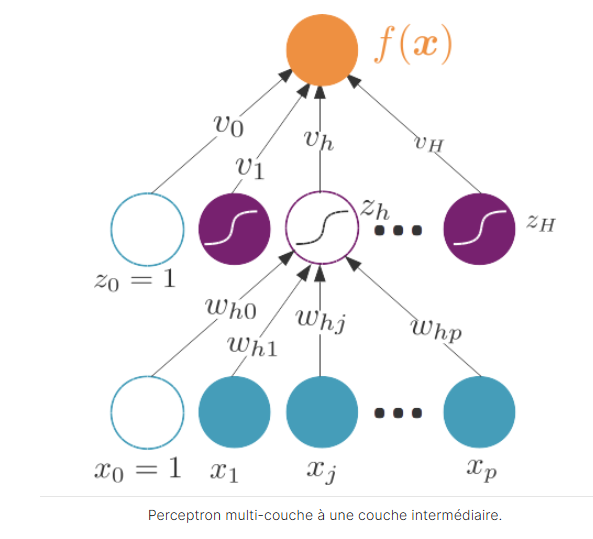


Ce modèle paramétrique a d'autant plus de paramètres (i.e. de poids de connexion) qu'il y a de couches intermédiaires et de neurones dans ces couches. Plus il y a de paramètres, plus il faut d'observations pour éviter le sur-apprentissage, et les réseaux de neurones profonds requièrent souvent des quantités massives de données pour bien fonctionner.

On peut interpréter un réseau de neurones multi-couche en considérant que la sortie de chaque couche intermédiaire est une nouvelle représentation des données. La puissance des réseaux de neurones multi-couche vient donc de leur capacité à apprendre une « bonne » représentation, autrement dit une représentation telle que le modèle linéaire (perceptron) entre la dernière couche intermédiaire et la sortie puisse être performant.

**Rétropropagation**

Comme pour le perceptron, nous allons utiliser un algorithme itératif basé sur l'algorithme du gradient. Pour faciliter les calculs, on utilise une idée de rétro-propagation des erreurs (ou backpropagation).

Il s'agit en fait de décomposer l'erreur grâce au théorème de dérivation des fonctions composées.

La mise à jour des poids peut donc se faire en alternant une phase forward (ou montante), dans laquelle les sorties des couches intermédiaires sont mises à jour, et une phase backward (ou descendante), dans laquelle le gradient de l'erreur par rapport aux poids d'une couche peut être calculé à partir du gradient de l'erreur par rapport aux poids d'une couche supérieure. La mise à jour des poids se fait au moment de la phase descendante (après que le gradient nécessaire ait été calculé).

**Conditionnement et minimums locaux**

Malheureusement, les dérivées de la fonction d'erreur utilisée dans un réseau de neurones multi-couche sont généralement mal conditionnées. Cela veut dire que si l'on perturbe un tout petit peu les conditions initiales de notre algorithme, le résultat sera très différent. En pratique, cela se voit en ce que la fonction d'erreur dessine beaucoup de puits et de montagnes.

Ainsi, la fonction d'erreur d'un réseau de neurones multi-couche admet un grand nombre de minimums locaux, c'est-à-dire de points qui sont optimaux dans leur voisinage. Ces points sont situés dans des puits. Ces points ne sont pas des minimums globaux, mais l'algorithme du gradient peut rester « coincé » dans un tel voisina

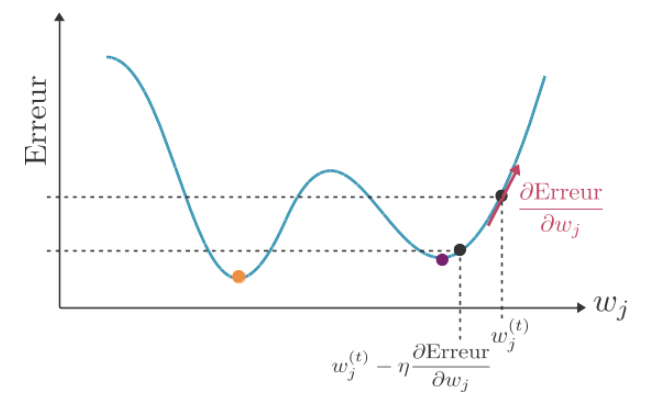ge.

**Instabilité du gradient**

Dans les architectures multi-couches, le gradient a tendance à être de plus en plus petit quand on redescend les couches cachées depuis la sortie vers l'entrée du réseau. Cela signifie que les neurones des couches basses apprennent beaucoup plus lentement que ceux des couches hautes.  C'est ce  qu'on appelle en anglais le phénomène de vanishing gradient (« disparition du gradient »).

À l'inverse, il est aussi possible que le gradient prenne des valeurs très grandes dans les couches basses, ce que l'on appelle « l'explosion du gradient » (exploding gradient).

Ce qu'il faut retenir, c'est que le gradient est instable. Cette instabilité est liée au fait que, dans la rétro-propagation, le gradient des couches basses est un produit de celui des couches hautes.

**Saturation**

La saturation est un phénomène qui apparaît quand la plupart des neurones à activation logistique du réseau ont une sortie à 0 ou 1 (-1 et + 1 pour une activation tangente hyperbolique), autrement dit quand la somme pondérée des signaux qu'ils reçoivent en entrée est trop grande (en valeur absolue). Cela signifie que les poids de connexion sont trop grands. À ce stade, un changement mineur dans les données d'entrée ne va quasiment pas avoir d'impact sur la sortie, et le réseau ne pourra plus apprendre (ou alors très lentement). De plus, un réseau saturé est souvent en situation de sur-apprentissage...

Une des stratégies que l'on peut utiliser pour éviter le sur-apprentissage est la régularisation. Eh oui, comme pour la régression linéaire ! Nous allons même utiliser le même régularisateur que pour la régression ridge : la norme l2 des poids de connexion. Contrôler cette norme permet en effet de contrôler la valeur absolue des poids, évitant ainsi que les sommes pondérées pré-activation soient trop grandes. Dans le monde des réseaux de neurones, cette technique s'appelle la dégradation des pondérations (« weight decay » en anglais).

### À vous de jouer ! - TP

In [84]:
data = pd.read_csv('ecg.csv', sep=',', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Vérifier que l’échantillon est bien équilibré (c’est à dire que la proportion des électrocardiogrammes sains et comportant une anomalie sont sensiblement identiques):

In [86]:
data.iloc[:,-1].value_counts(normalize=True).round(2)

140
1.0    0.58
0.0    0.42
Name: proportion, dtype: float64

In [87]:
# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data.iloc[:,-1].values

In [88]:
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [89]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.3 ) # 30% des données dans le jeu de test

Vous devrez utiliser les bibliothèques Keras et Tensorflow. Votre modèle comportera 2 couches de réseau de neurones avec une fonction d’activation de type sigmoïde pour chacune d’entre elles.

In [91]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

In [160]:
#Nous allons créer notre premier réseau de neurones. 

def initialize_model():
    
#Nous utilisons la fonction Sequential() qui est approprié pour notre problème. 
    model = models.Sequential()
    
#On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(keras.Input(shape=(140,)))
    
#On met la première couche de notre réseau de neurones. Nous avons une couche avec 140 perceptrons car nous avons
#140 colonnes dans nos données d'entrée comme dit plus haut. La fonction sigmoid est particulièrement indiqué
#pour les problèmes de classification. Nous vous encourageons à aller voir à quoi elle ressemble. 
    model.add(layers.Dense(140, input_dim=2, activation='sigmoid'))
    
#Nous ajoutons une seconde couche car nous sommes dans un problème non linéaire comme dit dans le cours
    model.add(layers.Dense(1, activation='sigmoid'))     # Dernière couche pour la classification binaire, par exemple
    
#Ici, nous pouvons ajouter des paramètres à notre modèle. Il faut juste retenir que "accuracy" permet d'avoir
#la précision de notre modèle et est particulièrement indiqué pour les problèmes de classification. 
    model.compile(metrics=['accuracy'],
                  loss='binary_crossentropy',
                  optimizer='adam')
    
    return model

In [162]:
model = initialize_model()

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
model.layers

[<Dense name=dense_6, built=True>, <Dense name=dense_7, built=True>]

In [164]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 140)            │        19,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           141 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,881 (77.66 KB)

 Trainable params: 19,881 (77.66 KB)

 Non-trainable params: 0 (0.00 B)

**Entrainement du modèle:**

In [169]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = 50,    # nbre d'itérations
                    batch_size = 4,     # nbre d'échantillon analysés à chaque itération
                    verbose = 1)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9685 - loss: 0.0941
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9905 - loss: 0.0315
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9918 - loss: 0.0211
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9956 - loss: 0.0181
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9975 - loss: 0.0144
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0162
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9957 - loss: 0.0168
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9976 - loss: 0.0135
Epoch 9/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9973 - loss: 0.0130
Epoch 10/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9985 - loss: 0.0111
Epoch 11/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9976 - loss: 0.0102
Epoch 12/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

875/875 :

Cela signifie que le modèle a traité 875 lots (batches) sur 875 au total. Autrement dit, l'entraînement pour cette epoch est terminé.
Le nombre de lots (batches) est lié à la taille des données d'entraînement et au paramètre batch_size que vous avez spécifié lors de l'entraînement du modèle.

loss: 0.0941 :

C'est la valeur de la fonction de perte (loss) après cette epoch. La fonction de perte mesure à quel point les prédictions du modèle sont éloignées des valeurs réelles. Plus la valeur de loss est basse, mieux le modèle apprend. Dans ce cas, 0.0941 est la perte après la première epoch.

In [174]:
y_pred = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [176]:
#On peut évaluer notre modèle
result = model.evaluate(X_test, y_test, verbose=1)

# On peut extraire la "metrics" choisie
accuracy = result[1]

print(f"La précision de notre modèle est de {round(accuracy*100,2)} %")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.1040
La précision de notre modèle est de 99.0 %


Empiler des perceptrons en un réseau de neurones multi-couches (feed-forward) permet de modéliser des fonctions arbitrairement complexes.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale !

Plus il y a de paramètres (i.e. de poids de connexion), plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

Il existe de nombreuses autres architectures de réseaux de neurones que celle présentée ici et qui permettent de modéliser des types de données particuliers (images, sons, dépendances temporelles...).